In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dense
from tensorflow.keras.constraints import max_norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load data

In [2]:
X_train = np.load('..\data\X_train_c.npy')  # population in F=1
Y_train = np.load('..\data\Y_train_c.npy')  #normalized to w_L

X_test = np.load('..\data\X_val_C.npy')  # use validation set for testing
Y_test = np.load('..\data\Y_val_C.npy')  # use validation set for testing

Normalize inputs

In [3]:
Level = np.min(X_train)
Height = np.max(X_train) - np.min(X_train)

X_train = (X_train - Level) / Height
X_test = (X_test - Level) / Height

Reshape data

In [4]:
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

Callbacks

In [5]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss', restore_best_weights=True) # Stop if the validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100) # Decrease the learning rate if the validation loss is not improving
cb_list = [early_stopping_cb, learning_rate_cb]

Initialize model

In [6]:
max_norm_value = 2.0

model = Sequential()
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=X_train[0].shape))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(320, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', padding='same'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='tanh', padding='same'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["mae"])

Training

In [7]:
noise_level = 0.01
X_test_N = X_test + np.random.normal(0, noise_level, X_test.shape)
X_train_N = X_train + np.random.normal(0, noise_level, X_train.shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["mae"])
history = model.fit(X_train_N, X_train, epochs=2000, validation_data=(X_test_N, X_test), batch_size=32, callbacks=cb_list, verbose=False)

Plot training history

(0.0, 0.1)

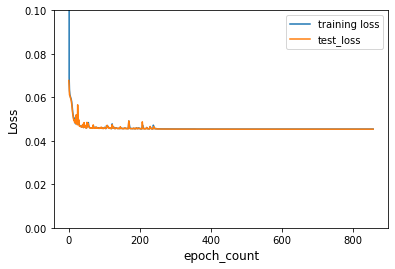

In [11]:
h = history.history

training_data = pd.DataFrame({"training loss": h["loss"], "test_loss": h["val_loss"]})
training_data.index.name = 'CNN Epoch'

fig = training_data.plot()
fig.set_xlabel(r'epoch_count', fontsize=12)
fig.set_ylabel(r'Loss', fontsize=12)
fig.set_ylim(0,0.1)

Visualize denoiser performance

8/8 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Predicted - Expected')

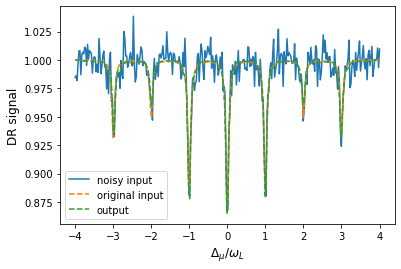

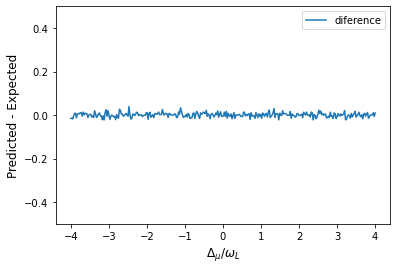

In [9]:
test = model.predict(X_test_N)  # Predicted output

index = 200

fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_test_N[index], label='noisy input')
ax.plot(np.linspace(-4,4,320), X_test[index], label='original input', ls='--')
ax.plot(np.linspace(-4,4,320), test[index], label='output', ls='--')
ax.legend(loc=0)
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)

fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_test_N[index] - X_test[index], label='diference')
ax.legend(loc=0)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('Predicted - Expected', fontsize=12)

Plot model

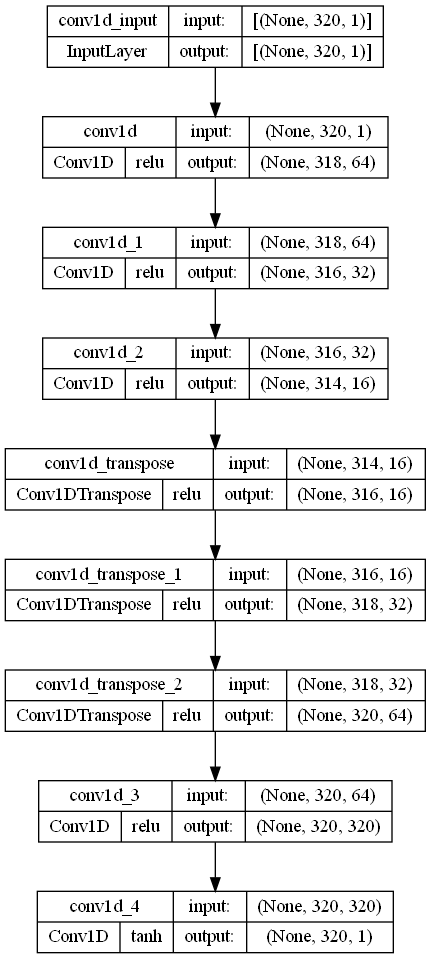

In [12]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png',show_layer_activations=True)

### Conclusions

Looks good, but when I try to integrate it with transfer learning, it does not help. Needs further investigation.